In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from catboost import CatBoostRegressor

# Data

In [2]:
df = pd.read_csv('../data/processed/train.csv')

In [3]:
df.sample(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
415,20,3,73.0,8899,1,1,0,3,0,4,...,0,3,4,1,0,8,2007,6,5,181134
1370,50,3,90.0,5400,1,1,3,3,0,0,...,0,3,4,1,0,10,2009,8,4,105000
473,20,3,110.0,14977,1,1,0,3,0,4,...,0,3,4,1,0,7,2007,6,5,440000


# Метрика

Мы хотим предсказать цену на недвижемость. Я считаю, что наиболее обоснованной метрикой качества нашей модели будет MAE, тк она легко интерпретируема заказчику - "На сколько в среднем в абсолютном значении ошибается наша модель".

# Baseline

Найдем baseline предсказаний различных дефолтных моделей, чтоб понять, что наша финальная модель будет лучше

In [8]:
scores_all_lr = []
scores_all_rf = []
scores_all_cb = []

for i in tqdm_notebook(range(25)):
    df_train, df_test = train_test_split(df, 
                                         test_size=0.3, 
                                         shuffle=True)

    lr = LinearRegression()
    rf = RandomForestRegressor()
    cb = CatBoostRegressor(verbose=False)

    lr.fit(df_train.drop(columns='SalePrice'), df_train['SalePrice'])
    rf.fit(df_train.drop(columns='SalePrice'), df_train['SalePrice'])
    cb.fit(df_train.drop(columns='SalePrice'), df_train['SalePrice'])

    y_pred_lr = lr.predict(df_test.drop(columns='SalePrice'))
    y_pred_rf = rf.predict(df_test.drop(columns='SalePrice'))
    y_pred_cb = cb.predict(df_test.drop(columns='SalePrice'))

    score_lr = mean_absolute_error(df_test['SalePrice'], y_pred_lr)
    score_rf = mean_absolute_error(df_test['SalePrice'], y_pred_rf)
    score_cb = mean_absolute_error(df_test['SalePrice'], y_pred_cb)

    scores_all_lr.append(score_lr)
    scores_all_rf.append(score_rf)
    scores_all_cb.append(score_cb)


/var/folders/gn/cj63fpv17w57ct5ns9hnv7n00000gn/T/ipykernel_43977/360962658.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(25)):


  0%|          | 0/25 [00:00<?, ?it/s]

LinearRegression mean score - 21824
RandomForestRegressor mean score - 17873
CatBoostRegressor mean score - 15131


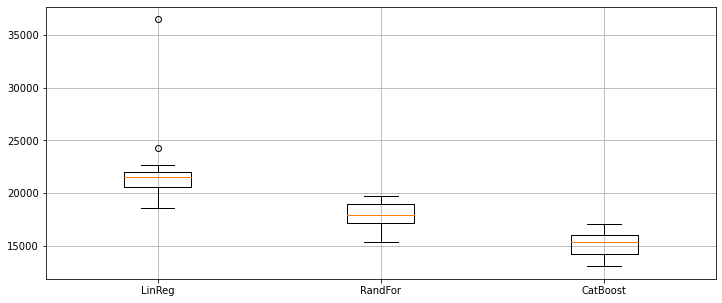

In [28]:
scores = [scores_all_lr, scores_all_rf, scores_all_cb]

print(f'LinearRegression mean score - {round(np.mean(scores_all_lr))}')
print(f'RandomForestRegressor mean score - {round(np.mean(scores_all_rf))}')
print(f'CatBoostRegressor mean score - {round(np.mean(scores_all_cb))}')

plt.figure(figsize=(12,5))

plt.boxplot(scores, 
            positions=range(len(scores)),
            labels = ['LinReg', 'RandFor', 'CatBoost'])

plt.grid()
plt.show()

Весьма неплохо. Мы CatBoost ошибается всего на 15131, что составляет отклонение в примерно 8%.

# Feature selection

Отберем фичи с помощью случайного леса

In [34]:
X_cols = df.drop(columns='SalePrice').columns
target = 'SalePrice'

In [38]:
features_per_target = {}

best_score = -np.inf
best_features = []

rf = RandomForestRegressor(n_estimators=600)

rf.fit(df[X_cols], df['SalePrice'])

feature_importances = [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

for f_imp in tqdm_notebook(feature_importances):
    if np.max(rf.feature_importances_) < f_imp:
        continue

    new_features = []

    for col, val in zip(X_cols, rf.feature_importances_):
        if val > f_imp:
            new_features.append(col)

    scores = []

    for i in range(10):

        df_train, df_test = train_test_split(df, 
                                             test_size=0.3, 
                                             shuffle=True)

        cb = CatBoostRegressor(verbose=False)
        cb.fit(df_train[new_features], df_train[target])
        y_pred_cb = cb.predict(df_test[new_features])
        score_cb = mean_absolute_error(df_test[target], y_pred_cb)

        scores.append(score_cb)


    mean_score = np.mean(scores)
    print(f'For feature importance {f_imp}')
    print(f'Score - {round(mean_score,3)}')
    print()

    if mean_score < best_score:
        best_score = mean_score
        best_features = new_features

/var/folders/gn/cj63fpv17w57ct5ns9hnv7n00000gn/T/ipykernel_43977/3007967118.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for f_imp in tqdm_notebook(feature_importances):


  0%|          | 0/11 [00:00<?, ?it/s]

For feature importance 1e-05
Score - 15088.207

For feature importance 0.0001
Score - 15286.724

For feature importance 0.001
Score - 15113.735

For feature importance 0.005
Score - 16249.432

For feature importance 0.01
Score - 19796.225

For feature importance 0.05
Score - 25764.325

For feature importance 0.06
Score - 26680.537

For feature importance 0.07
Score - 26617.738

For feature importance 0.08
Score - 26469.109

For feature importance 0.09
Score - 27159.355

For feature importance 0.1
Score - 26242.896



Видимо будем использовать все фичи

# Model tuning

По заданию мы должны использовать Catboost, поэтому будем тюнить его

In [39]:
categorial_cols = ['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [40]:
for col in categorial_cols:
    df[col] = df[col].astype(int)

Поиск по сетке

In [45]:
cbc = CatBoostRegressor(verbose=False, 
                         cat_features=categorial_cols,
                         )

#create the grid
grid = {'max_depth': [5,6,7,8,9,10],
        'n_estimators':[300,400,500,600],
        'min_child_samples':[4,8,12,16,20],
        'l2_leaf_reg':[0.5,1,5]}

#Instantiate GridSearchCV
gscv = GridSearchCV(estimator = cbc, param_grid = grid, scoring ='explained_variance', cv = 3, n_jobs=2)

#fit the model
gscv.fit(df[X_cols], df[target])

#returns the estimator with the best performance
print(gscv.best_estimator_)

#returns the best score
print(gscv.best_score_)

#returns the best parameters
print(gscv.best_params_)

/Users/vladimirkulichenko/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.9018822193381107
{'l2_leaf_reg': 0.5, 'max_depth': 5, 'min_child_samples': 4, 'n_estimators': 600}


## config

In [ ]:
model_params = {'l2_leaf_reg': 0.5, 'max_depth': 5, 'min_child_samples': 4, 'n_estimators': 600}

In [51]:
X_cols

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo